In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import hist

In [2]:
import awkward as ak
import vector
vector.register_awkward()

In [3]:
tree = uproot.open("vertexml.root:tree")
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rec_q                | float                    | AsDtype('>f4')
rec_x1               | float                    | AsDtype('>f4')
rec_y1               | float                    | AsDtype('>f4')
rec_z1               | float                    | AsDtype('>f4')
rec_x3               | float                    | AsDtype('>f4')
rec_y3               | float                    | AsDtype('>f4')
rec_z3               | float                    | AsDtype('>f4')
rec_px1              | float                    | AsDtype('>f4')
rec_py1              | float                    | AsDtype('>f4')
rec_pz1              | float                    | AsDtype('>f4')
rec_px3              | float                    | AsDtype('>f4')
rec_py3              | float                    | AsDtype('>f4')
rec_pz3              | float                    | AsDtype(

In [4]:
dim_tree = uproot.open("dim_tree.root:tree/true_dim")
dim_tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
true_dim             | dim                      | AsGroup(<TBranchElement 'true_
rec_stat             | int32_t                  | AsDtype('>i4')
weight               | double                   | AsDtype('>f8')
mass                 | double                   | AsDtype('>f8')
energy               | double                   | AsDtype('>f8')
pt                   | double                   | AsDtype('>f8')


In [5]:
import pandas as pd

dim_data = dim_tree.arrays(["rec_stat", "weight", "mass", "energy", "pt"], library="pd")
dim_data = dim_data.to_numpy()

dim_data

array([[0.00000000e+00, 6.95888766e-01, 9.59306747e+00, 7.56326543e+01,
        1.22403315e+00],
       [0.00000000e+00, 4.47164724e-02, 9.62898408e+00, 1.12274902e+02,
        1.03601771e+00],
       [0.00000000e+00, 9.57233153e-02, 9.65211553e+00, 1.08798330e+02,
        3.28330712e-01],
       ...,
       [0.00000000e+00, 2.73176619e+01, 5.02388211e+00, 1.11345359e+02,
        1.08727832e+00],
       [0.00000000e+00, 4.01051844e+01, 7.70917778e+00, 7.07505655e+01,
        1.06563181e+00],
       [0.00000000e+00, 6.91400317e+03, 2.71767407e+00, 9.82194232e+01,
        8.92520136e-01]])

In [6]:
from sklearn.model_selection import train_test_split

X_train_val, X_test = train_test_split(dim_data, test_size=0.2)

X_test

array([[ 0.00000000e+00,  1.33874352e+00,  9.01762541e+00,
         9.62749430e+01,  5.27750086e-01],
       [ 0.00000000e+00,  6.25863339e-01,  7.04196228e+00,
         1.15370479e+02,  1.42254516e+00],
       [-1.00000000e+01,  6.69579322e+03,  4.70010580e+00,
         6.80553549e+01,  5.49444753e-01],
       ...,
       [ 0.00000000e+00,  1.68537286e+02,  1.85471105e+00,
         1.18371812e+02,  1.67280674e+00],
       [ 0.00000000e+00,  3.64923790e+01,  7.80983781e+00,
         7.27130118e+01,  3.70228594e-01],
       [ 0.00000000e+00,  1.29566036e+00,  7.72667196e+00,
         1.10217136e+02,  1.24866911e+00]])

In [7]:
data = tree.arrays(library="ak")

In [8]:
mu_mass = 0.106 #muon mass in GeV

tracks = ak.zip({
    "charge": data["rec_q"],
    "momentum": ak.zip({
        "px": data["rec_vpx"],
        "py": data["rec_vpy"],
        "pz": data["rec_vpz"],
        "mass": mu_mass,
    }, with_name="Momentum4D"),
    "position": ak.zip({
        "x": data["rec_vtx"],
        "y": data["rec_vty"],
        "z": data["rec_vtz"],
    }, with_name="Vector3D")
}, depth_limit=1)

In [9]:
mu1, mu2 = ak.unzip(ak.combinations(tracks, 2, axis=0))

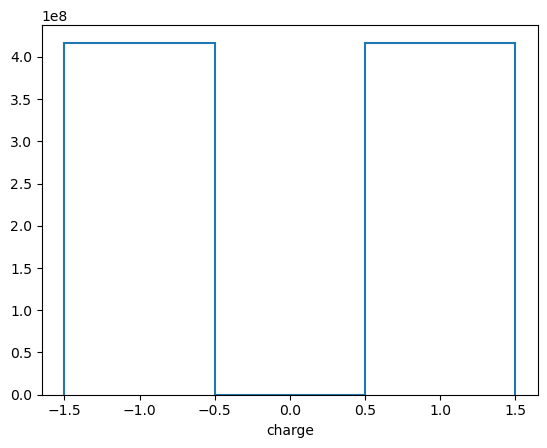

In [10]:
hist.Hist.new.Regular(3, -1.5, 1.5).Double().fill(ak.ravel(mu1.charge)).plot()
plt.xlabel("charge")
plt.show()

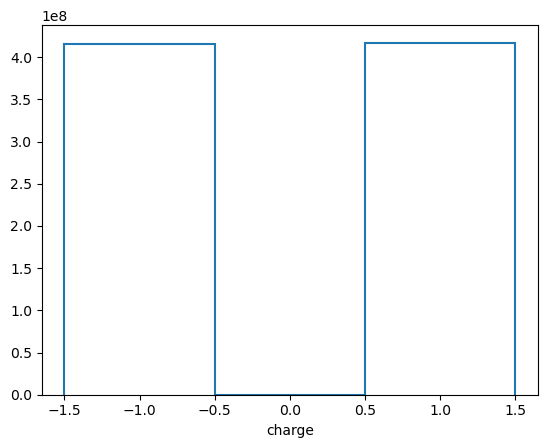

In [11]:
hist.Hist.new.Regular(3, -1.5, 1.5).Double().fill(ak.ravel(mu2.charge)).plot()
plt.xlabel("charge")
plt.show()

In [12]:
charge_selection = mu1.charge + mu2.charge == 0

In [13]:
dimu_mass = (mu1.momentum[charge_selection] + mu2.momentum[charge_selection])

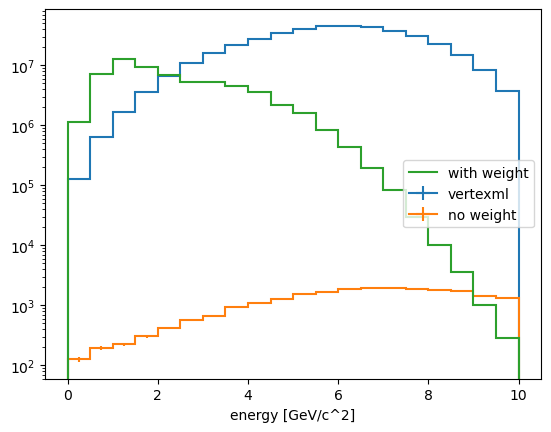

In [14]:
hist.Hist.new.Regular(20, 0., 10.).Double().fill(ak.ravel(dimu_mass.mass)).plot(label="vertexml")
hist.Hist.new.Regular(20, 0., 10.).Double().fill(X_test[:, 2]).plot(label="no weight")
hist.Hist.new.Regular(20, 0., 10.).Double().fill(X_test[:, 2], weight=X_test[:, 1]).plot(label="with weight")
plt.xlabel("energy [GeV/c^2]")
plt.yscale("log")
plt.legend()
plt.savefig("imgs/mass.png")
plt.show()

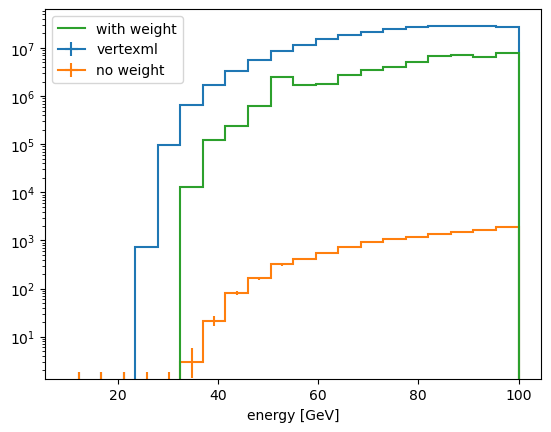

In [15]:
hist.Hist.new.Regular(20, 10., 100.).Double().fill(ak.ravel(dimu_mass.energy)).plot(label="vertexml")
hist.Hist.new.Regular(20, 10., 100.).Double().fill(X_test[:, 3]).plot(label="no weight")
hist.Hist.new.Regular(20, 10., 100.).Double().fill(X_test[:, 3], weight=X_test[:, 1]).plot(label="with weight")
plt.xlabel("energy [GeV]")
plt.yscale("log")
plt.legend()
plt.savefig("imgs/energy.png")
plt.show()

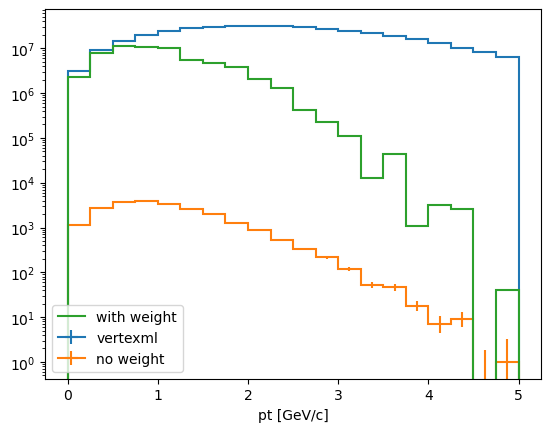

In [16]:
hist.Hist.new.Regular(20, 0., 5.).Double().fill(ak.ravel(dimu_mass.pt)).plot(label="vertexml")
hist.Hist.new.Regular(20, 0., 5.).Double().fill(X_test[:, 4]).plot(label="no weight")
hist.Hist.new.Regular(20, 0., 5.).Double().fill(X_test[:, 4], weight=X_test[:, 1]).plot(label="with weight")
plt.xlabel("pt [GeV/c]")
plt.yscale("log")
plt.legend()
plt.savefig("imgs/pt.png")
plt.show()

In [3]:
a = ak.Array([["a", "b", "c"], ["d", "e", "f"], ["g", "h", "i"]])

b, c = ak.unzip(ak.combinations(a, 2, axis=0))

In [14]:
ak.to_list(b)

[['a', 'b', 'c'], ['a', 'b', 'c'], ['d', 'e', 'f']]

In [9]:
ak.to_list(ak.combinations(a, 2, axis=0))

[(['a', 'b', 'c'], ['d', 'e', 'f']),
 (['a', 'b', 'c'], ['g', 'h', 'i']),
 (['d', 'e', 'f'], ['g', 'h', 'i'])]